# Data Preprocessing
Download and preprocess data for 10 stocks from teh Dow Jones Industrial Average.

## Setup

In [1]:
# make the current working directory the project root directory
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import talib as ta
from tqdm.notebook import tqdm

## Download Data

In [3]:
TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']

# 9 years of pre COVID-19 data
TRAIN_START = '2010-01-01'
TRAIN_END = '2019-12-31'

# 1 year of heavily COVID-19 affected data and 1 year of post COVID-19 growth
VAL_START = '2020-01-01'
VAL_END = '2021-12-31'

# 1 year of recession period
TEST_START = '2022-01-01'
TEST_END = '2022-12-31'

In [4]:
data = {}
for ticker in tqdm(TICKERS):
    data[ticker] = yf.download(
        ticker,
        start = TRAIN_START,
        end = TEST_END,
        interval = '1d',
        progress = False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# data['AXP'].head()

In [6]:
# Check for missing data
total_missing = 0
for ticker in TICKERS:
    total_missing += data[ticker].isna().sum().sum()
print(f'Total missing: {total_missing}')

Total missing: 0


## Feature Generation Example

In [7]:
ticker = 'AXP'
df = pd.DataFrame(index=data[ticker].index)

#### Daily Return

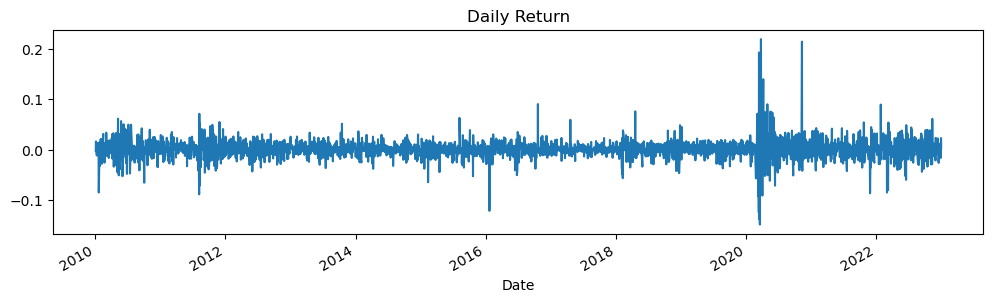

In [8]:
df['RETURN'] = data[ticker]['Adj Close'].pct_change(1)
df.RETURN.plot(title='Daily Return', figsize=(12,3));

#### Scaled Value

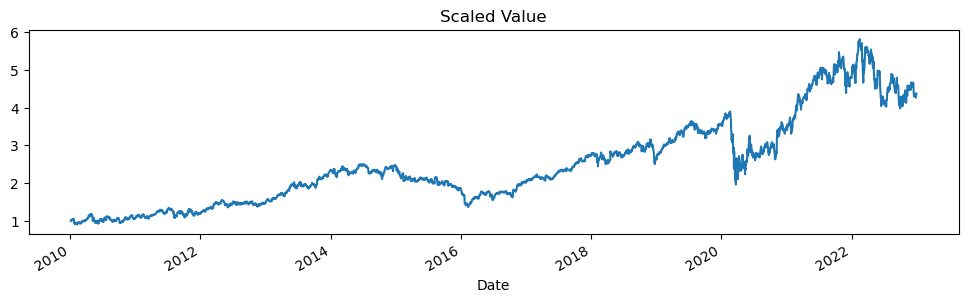

In [9]:
df['VALUE'] = data[ticker]['Adj Close'] / data[ticker]['Adj Close'][0]
df.VALUE.plot(title='Scaled Value', figsize=(12,3));

#### MACD

https://www.investopedia.com/terms/m/macd.asp

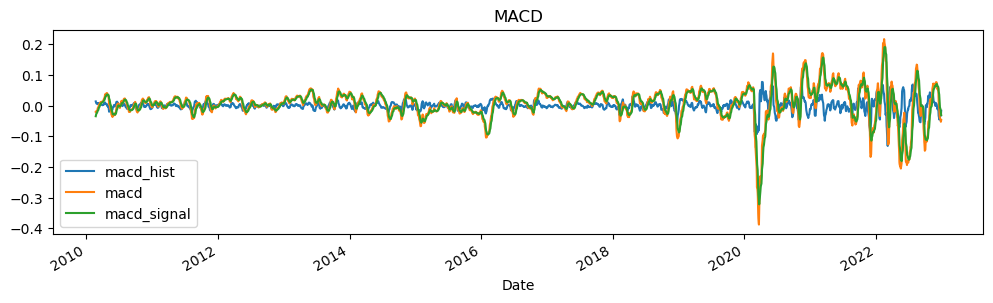

In [10]:
macd, macd_signal, macd_hist = ta.MACD(df.VALUE)

df['MACD'] = macd_hist # macd_hist = macd - macd_signal <-- Traders use this to identify when bullish or bearish momentum is high

# Plots
df.MACD.plot(title='MACD', figsize=(12,3), label='macd_hist') 
macd.plot(label='macd'); # (12-period EMA) - (26-period EMA)
macd_signal.plot(label='macd_signal'); # 9 day EMA of teh MACD line
plt.legend();

#### RSI

https://www.investopedia.com/terms/r/rsi.asp

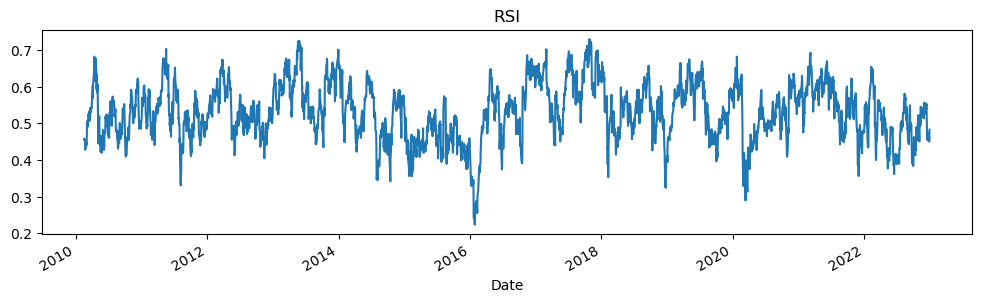

In [11]:
df['RSI'] = ta.RSI(df.VALUE, timeperiod=30)/100 # Rescale to between 0 and 1
df.RSI.plot(title='RSI', figsize=(12,3));

#### Bollinger Bands

https://www.investopedia.com/terms/b/bollingerbands.asp

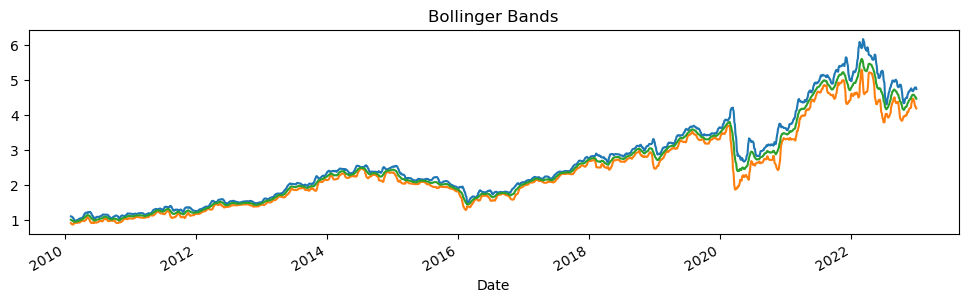

In [12]:
upper_band, middle_band, lower_band = ta.BBANDS(df.VALUE, timeperiod=20)

df['BOLL_UPPER'] = upper_band # middle_band + 2 standard deviations (over 20 days)
df['BOLL_LOWER'] = lower_band # middle_band - 2 standard deviations (over 20 days)

df.BOLL_UPPER.plot(title='Bollinger Bands', figsize=(12,3));
df.BOLL_LOWER.plot();
middle_band.plot(); # 20 say SMA

#### CCI

https://www.investopedia.com/terms/c/commoditychannelindex.asp

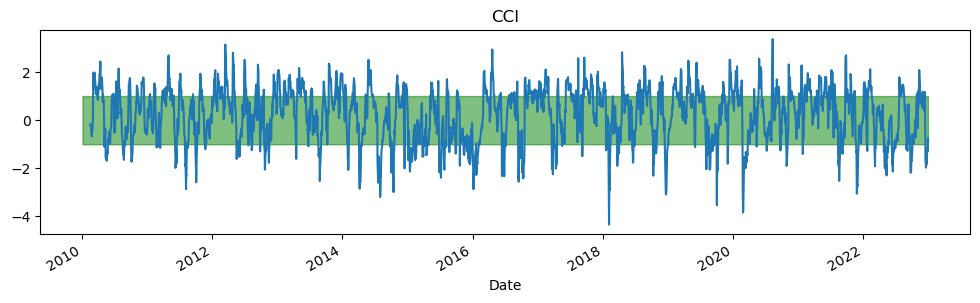

In [13]:
df['CCI'] = ta.CCI(data[ticker]['High'], data[ticker]['Low'], data[ticker]['Close'], timeperiod=30)/100
df.CCI.plot(title='CCI', figsize=(12,3));
plt.fill_between(x=df.index, y1=-1, y2=1, color='g', alpha=0.5);

#### DX

https://www.investopedia.com/terms/d/dmi.asp

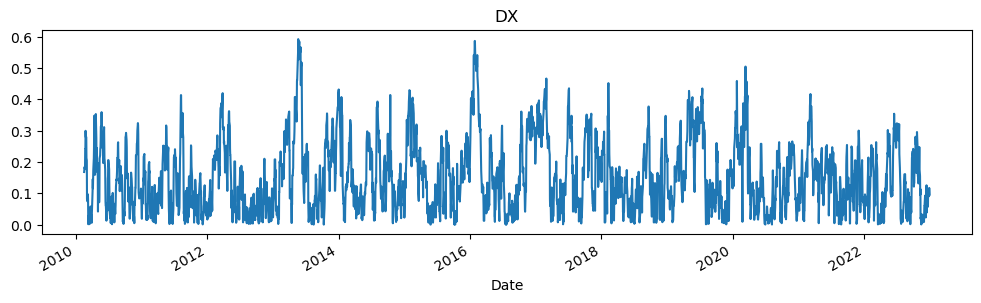

In [14]:
df['DX'] = ta.DX(data[ticker]['High'], data[ticker]['Low'], data[ticker]['Close'], timeperiod=30)/100
df.DX.plot(title='DX', figsize=(12,3));

#### Moving Averages

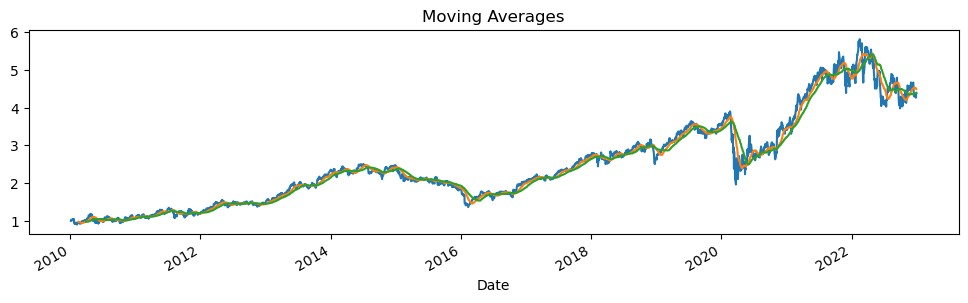

In [15]:
df['SMA_30'] = ta.SMA(df.VALUE, timeperiod=30)
df['SMA_60'] = ta.SMA(df.VALUE, timeperiod=60)

df.VALUE.plot(title='Moving Averages', figsize=(12,3));
df.SMA_30.plot();
df.SMA_60.plot();

#### Drop `na` rows

In [16]:
df = df.dropna() # drop the first 3 months of data
df.head()

,RETURN,VALUE,MACD,RSI,BOLL_UPPER,BOLL_LOWER,CCI,DX,SMA_30,SMA_60
Date,,,,,,,,,,
2010-03-30,-0.000242,1.017856,0.002408,0.543074,1.036364,0.952100,0.932501,0.029925,0.978037,0.977058
2010-03-31,-0.000727,1.017116,0.001881,0.541796,1.033066,0.963155,0.840423,0.005620,0.979992,0.977343
2010-04-01,0.010664,1.027963,0.002040,0.557586,1.032868,0.970695,1.021397,0.035066,0.982227,0.977846
2010-04-05,0.023261,1.051874,0.003450,0.589820,1.042192,0.967891,1.335987,0.106250,0.985333,0.978478
2010-04-06,0.010547,1.062968,0.004744,0.603679,1.051749,0.967164,1.496499,0.144742,0.988915,0.979021


#### Visualizations and Scales

In [17]:
df.describe()

,RETURN,VALUE,MACD,RSI,BOLL_UPPER,BOLL_LOWER,CCI,DX,SMA_30,SMA_60
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,0.000625,2.518076,-0.000051,0.531379,2.642201,2.373951,0.231302,0.151292,2.502518,2.486185
std,0.018608,1.148704,0.017379,0.077596,1.227442,1.068118,1.103621,0.111560,1.140558,1.133221
min,-0.148187,0.929604,-0.130861,0.223953,1.021257,0.899034,-4.337235,0.000031,0.978037,0.977058
25%,-0.007106,1.638451,-0.006246,0.478482,1.736716,1.549642,-0.562782,0.062271,1.637891,1.617194
50%,0.000682,2.269916,0.000335,0.532970,2.364510,2.141068,0.397207,0.127855,2.281839,2.277780
75%,0.009045,3.066671,0.006676,0.585529,3.214222,2.900829,1.071485,0.221180,3.005215,2.980755
max,0.218823,5.809877,0.077904,0.730379,6.160112,5.287911,3.363548,0.591723,5.428844,5.411542


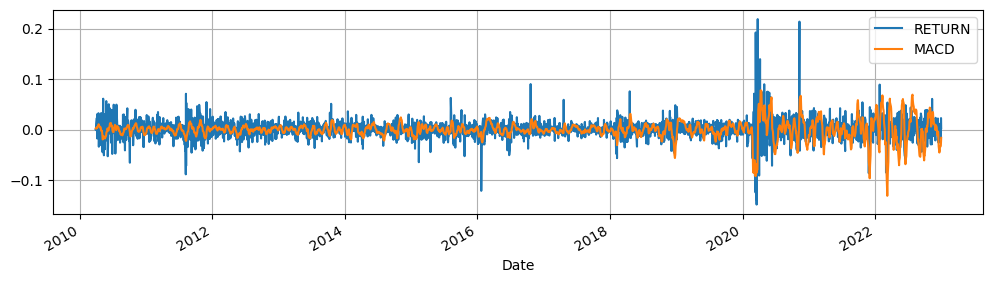

In [18]:
df[['RETURN', 'MACD']].plot(figsize=(12, 3), grid=True);

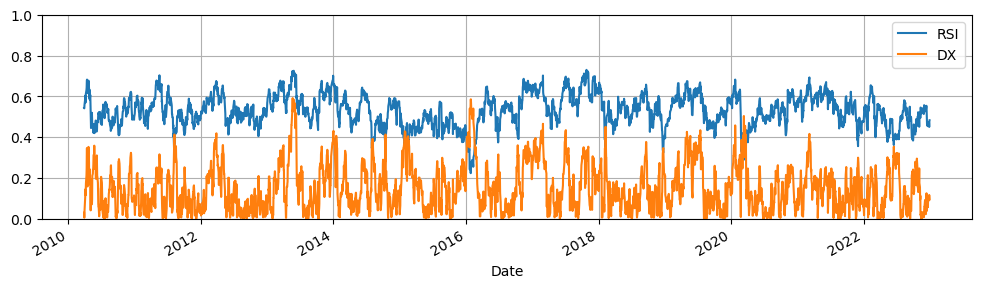

In [19]:
df[['RSI', 'DX']].plot(figsize=(12, 3), grid=True);
plt.ylim(0, 1);

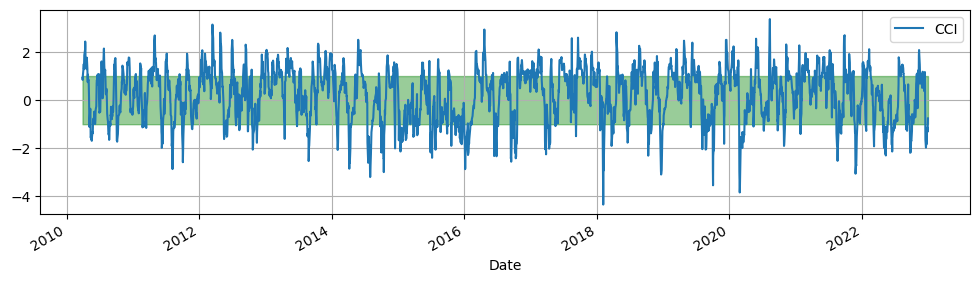

In [20]:
df[['CCI']].plot(figsize=(12, 3), grid=True);
plt.fill_between(df.index, -1, 1, color='g', alpha=0.4);

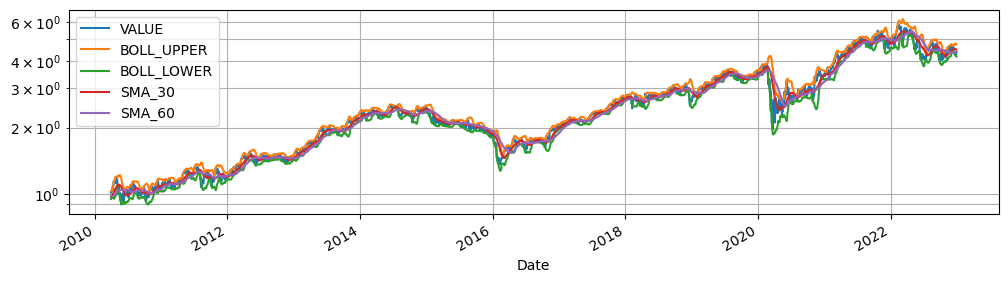

In [21]:
df[['VALUE', 'BOLL_UPPER', 'BOLL_LOWER', 'SMA_30', 'SMA_60']].plot(figsize=(12, 3));
plt.yscale('log');
plt.grid(which='both');

## Generate Features

In [22]:
dataset = pd.DataFrame(index = data[TICKERS[0]].index)
for ticker in tqdm(TICKERS):
    dataset[f'{ticker}_RETURN'] = data[ticker]['Adj Close'].pct_change(1)
    dataset[f'{ticker}_VALUE'] = data[ticker]['Adj Close'] / data[ticker]['Adj Close'][0]
    _, _, dataset[f'{ticker}_MACD'] = ta.MACD(dataset[f'{ticker}_VALUE'])
    dataset[f'{ticker}_RSI'] = ta.RSI(dataset[f'{ticker}_VALUE'], timeperiod=30)/100
    dataset[f'{ticker}_BOLL_UPPER'], _, dataset[f'{ticker}_BOLL_LOWER'] = ta.BBANDS(dataset[f'{ticker}_VALUE'], timeperiod=20)
    dataset[f'{ticker}_CCI'] = ta.CCI(data[ticker]['High'], data[ticker]['Low'], data[ticker]['Close'], timeperiod=30)/100
    dataset[f'{ticker}_DX'] = ta.DX(data[ticker]['High'], data[ticker]['Low'], data[ticker]['Close'], timeperiod=30)/100
    dataset[f'{ticker}_SMA_30'] = ta.SMA(dataset[f'{ticker}_VALUE'], timeperiod=30)
    dataset[f'{ticker}_SMA_60'] = ta.SMA(dataset[f'{ticker}_VALUE'], timeperiod=60)
dataset = dataset.dropna()

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
display(dataset.head())
print(f'Shape: {dataset.shape}')

,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-30,-0.000242,1.017856,0.002408,0.543074,1.036364,0.952100,0.932501,0.029925,0.978037,0.977058,...,-0.001707,1.094481,0.002663,0.648236,1.109108,1.000060,1.134739,0.338868,1.027929,0.989372
2010-03-31,-0.000727,1.017116,0.001881,0.541796,1.033066,0.963155,0.840423,0.005620,0.979992,0.977343,...,-0.005413,1.088556,0.001522,0.632101,1.106320,1.013044,1.069415,0.338868,1.032138,0.990848
2010-04-01,0.010664,1.027963,0.002040,0.557586,1.032868,0.970695,1.021397,0.035066,0.982227,0.977846,...,0.018333,1.108513,0.001763,0.661463,1.110985,1.017671,1.245733,0.376320,1.036847,0.992698
2010-04-05,0.023261,1.051874,0.003450,0.589820,1.042192,0.967891,1.335987,0.106250,0.985333,0.978478,...,-0.009283,1.098223,0.000925,0.634454,1.114411,1.020482,1.132393,0.376320,1.040994,0.994465
2010-04-06,0.010547,1.062968,0.004744,0.603679,1.051749,0.967164,1.496499,0.144742,0.988915,0.979021,...,0.007098,1.106018,0.000605,0.645789,1.118341,1.023660,1.149767,0.383033,1.045515,0.996357


Shape: (3213, 100)


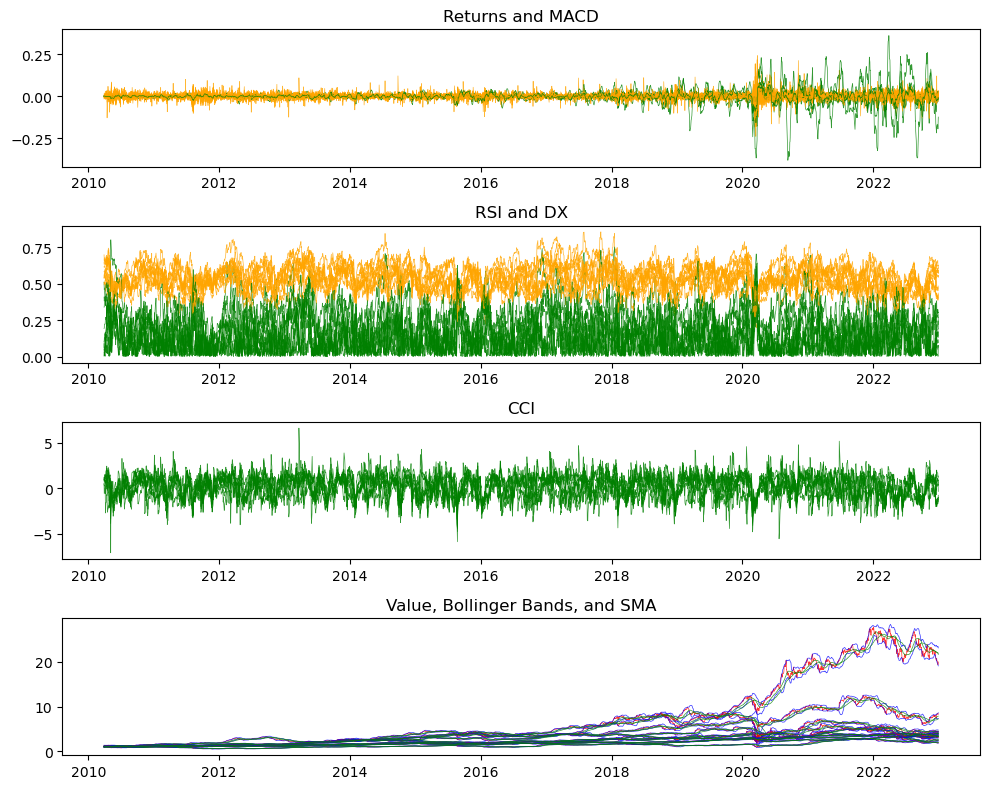

In [24]:
# Plot ranges
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
for ticker in TICKERS:
    axes[0].set_title('Returns and MACD')
    axes[0].plot(dataset[f'{ticker}_RETURN'], color='orange', lw=0.5, alpha=0.8)
    axes[0].plot(dataset[f'{ticker}_MACD'], color='green', lw=0.5, alpha=0.8)
    
    axes[1].set_title('RSI and DX')
    axes[1].plot(dataset[f'{ticker}_RSI'], color='orange', lw=0.5, alpha=0.8)
    axes[1].plot(dataset[f'{ticker}_DX'], color='green', lw=0.5, alpha=0.8)
    
    axes[2].set_title('CCI')
    axes[2].plot(dataset[f'{ticker}_CCI'], color='green', lw=0.5, alpha=0.8)
    
    axes[3].set_title('Value, Bollinger Bands, and SMA')
    axes[3].plot(dataset[f'{ticker}_VALUE'], color='red', lw=0.5, alpha=0.8)
    axes[3].plot(dataset[f'{ticker}_BOLL_UPPER'], color='blue', lw=0.5, alpha=0.8)
    axes[3].plot(dataset[f'{ticker}_BOLL_LOWER'], color='blue', lw=0.5, alpha=0.8)
    axes[3].plot(dataset[f'{ticker}_SMA_30'], color='green', lw=0.5, alpha=0.8)
    axes[3].plot(dataset[f'{ticker}_SMA_60'], color='green', lw=0.5, alpha=0.8)

plt.tight_layout()

## Train-Val-Test Split

In [25]:
train_dataset = dataset[TRAIN_START : TRAIN_END]
display(train_dataset.head(1))
display(train_dataset.tail(1))

,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-30,-0.000242,1.017856,0.002408,0.543074,1.036364,0.9521,0.932501,0.029925,0.978037,0.977058,...,-0.001707,1.094481,0.002663,0.648236,1.109108,1.00006,1.134739,0.338868,1.027929,0.989372


,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.001529,3.531804,0.000622,0.564609,3.637531,3.32698,0.711814,0.11548,3.451507,3.400852,...,0.005982,5.177576,-0.024267,0.538936,5.316606,5.151938,-1.466224,0.093309,5.26068,4.997545


In [26]:
val_dataset = dataset[VAL_START : VAL_END]
display(val_dataset.head(1))
display(val_dataset.tail(1))

,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.014428,3.582763,0.002002,0.592313,3.634732,3.357345,0.9466,0.174146,3.457773,3.406827,...,0.024684,5.305378,-0.014436,0.582525,5.320172,5.150179,-0.166961,0.1794,5.262385,5.008332


,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,-0.003411,4.779293,0.020435,0.474562,4.95946,4.572251,0.07511,0.07026,4.771231,4.975456,...,-0.00667,5.544872,0.044872,0.461106,5.619109,5.229888,1.105887,0.076059,5.401832,5.749587


In [27]:
test_dataset = dataset[TEST_START : TEST_END]
display(test_dataset.head(1))
display(test_dataset.tail(1))

,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.028179,4.913967,0.027472,0.509725,4.961927,4.605628,0.595326,0.017542,4.76344,4.972496,...,0.012073,5.611815,0.045201,0.480047,5.63375,5.252978,1.360018,0.053556,5.40324,5.737087


,AXP_RETURN,AXP_VALUE,AXP_MACD,AXP_RSI,AXP_BOLL_UPPER,AXP_BOLL_LOWER,AXP_CCI,AXP_DX,AXP_SMA_30,AXP_SMA_60,...,DIS_RETURN,DIS_VALUE,DIS_MACD,DIS_RSI,DIS_BOLL_UPPER,DIS_BOLL_LOWER,DIS_CCI,DIS_DX,DIS_SMA_30,DIS_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,0.002919,4.372245,-0.016119,0.483186,4.732496,4.178864,-0.757763,0.095606,4.488523,4.390649,...,-0.003441,3.110197,-0.007694,0.422642,3.526435,2.948883,-1.039333,0.132217,3.305945,3.416641


### Save to `.csv` file

In [28]:
dataset.to_csv('data/dow_10_ta_dataset.csv')
train_dataset.to_csv('data/dow_10_ta_train_dataset.csv')
val_dataset.to_csv('data/dow_10_ta_val_dataset.csv')
test_dataset.to_csv('data/dow_10_ta_test_dataset.csv')